In [46]:
import sys
import os
import time
import random

import torch
import torch.nn.functional as F
import torch.nn as nn

import tensorflow as tf
from tensorflow import distributions as ds
import anndata as ad
import numpy as np

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.chemicalvae.chemicalVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import TFVAEZ_CheckNet2Net
from perturbnet.cinn.FeatureAttr import *
import pickle


import umap
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns


from collections import defaultdict
from captum.attr import IntegratedGradients


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load cinn

In [ ]:
some_path = ""
path_cinn_model = some_path + '/PerturbNet/holdout1/cinn_iso_clean/100ep/100ep/'
path_data = './../adata_downsampled_k30.h5ad '
path_chemvae_model = some_path + "/chemicalvae/zinc/model_params_525.pt"

path_vae_model_train = some_path  + '/PerturbNet/holdout1/cellvae/150ep/model/'
path_chem_onehot = some_path  + "/zinc/"

adata_downsampled = ad.read_h5ad("./../example_data/adata_downsampled_k30.h5ad")

data_chem_onehot = np.load(os.path.join(path_chem_onehot, "onehot_zinc.npy"))


vae_train = VAE(num_cells_train = adata_downsampled.X.shape[0], x_dimension = adata_downsampled.X.shape[1], learning_rate = 1e-4, BNTrainingMode = False)
vae_train.restore_model(tf.train.latest_checkpoint(path_vae_model_train))

device = "cuda" if torch.cuda.is_available() else "cpu"

model_chemvae = ChemicalVAE(n_char = data_chem_onehot.shape[2],max_len = data_chem_onehot.shape[1]).to(device)
model_chemvae.load_state_dict(torch.load(path_chemvae_model, map_location = device))
model_chemvae.eval()

std_model = Standardize(data_all = data_chem_onehot, model = model_chemvae, device = device)


In [4]:
trt_obs_list = np.unique(np.array(adata_downsampled.obs["perturb_string"]))
perturbToOnehot = {}
for i in range(trt_obs_list.shape[0]):
    perturbToOnehot[trt_obs_list[i]] = i    
onehot_seen_idx = []
for i in range(len(trt_obs_list)):
    trt = trt_obs_list[i]
    onehot_idx = np.where(adata_downsampled.uns["ordered_all_smile"] == trt)[0][0]
    onehot_seen_idx.append(onehot_idx)
seen_onehot = adata_downsampled.uns["ordered_all_onehot"][onehot_seen_idx]    
## cinn

        
        
torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim = 196,embedding_dim = 10, conditioning_depth = 2, n_flows = 20, 
                               in_channels = 10, hidden_dim = 1024, hidden_depth = 2, activation = "none", conditioner_use_bn = True)

model_c = Net2NetFlow_TFVAEFlow(configured_flow = flow_model, first_stage_data = adata_downsampled.X, 
                                cond_stage_data = np.array(adata_downsampled.obs["perturb_string"]),
                          perturbToOnehotLib = perturbToOnehot, oneHotData = seen_onehot, model_con = model_chemvae, 
                          std_model = std_model,sess = vae_train.sess, enc_ph = vae_train.x, z_gen_data_v = vae_train.z_mean,
                          is_training = vae_train.is_training)

model_c.to(device = device)
#model_c.train(n_epochs = 1, batch_size = 128, lr = 4.5e-6)
model_c.load(path_cinn_model)
model_c.eval()

model_g = model_c.model_con
model_g.eval()

perturbnet_model = TFVAEZ_CheckNet2Net(model_c, device, vae_train.sess, vae_train.x_hat, vae_train.z_mean, vae_train.is_training)


Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size


# Umap of the cluster

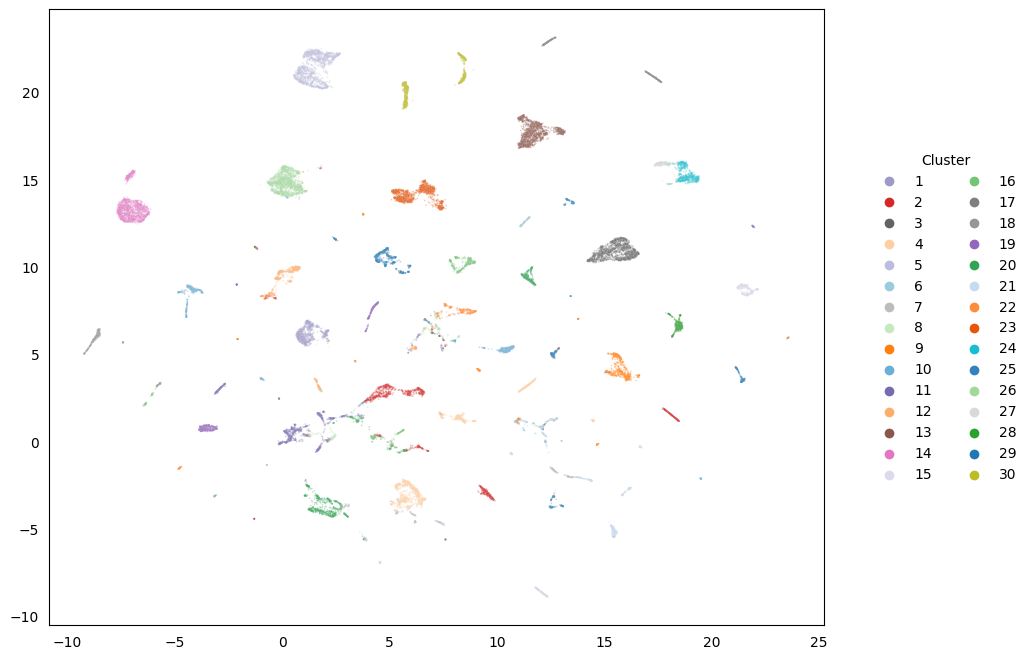

In [24]:
umap_z = adata_downsampled.obsm["umap_z"]
kmeans_cluster = adata_downsampled.obs["Kmeans30"].to_numpy() + 1


colors_tab20c = plt.cm.get_cmap('tab20c', 20).colors
colors_tab10 = plt.cm.get_cmap('tab10', 10).colors
custom_palette = sns.color_palette(list(colors_tab20c) + list(colors_tab10))

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=umap_z[:, 0], y=umap_z[:, 1], hue=kmeans_cluster.astype(str), palette=custom_palette, s=1.5, alpha=0.3)


handles, labels = scatter.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: int(x[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)


legend = plt.legend(sorted_handles, sorted_labels, title='Cluster', bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2, frameon=False)


scatter.tick_params(left=False, bottom=False)


scatter.set_title('')
scatter.set_xlabel('')
scatter.set_ylabel('')

figure_box = plt.gcf().get_window_extent()

plt.show()

# Example of training classifier for a specific cluster

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


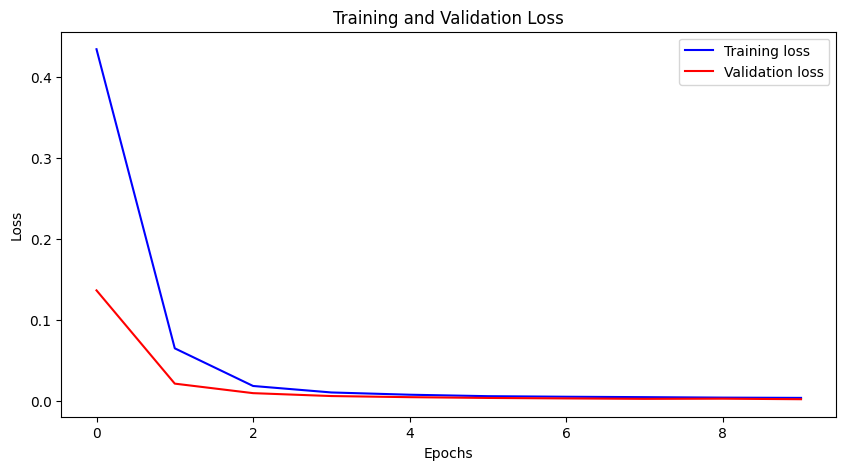

In [18]:
cell_states = adata_downsampled.obsm["cellstates"]
labels = adata_downsampled.obs["Kmeans30"]

# Convert to numpy arrays
labels = labels.to_numpy()

# For binary classification, convert the labels accordingly
# For simplicity, we'll consider cluster '0' vs. the rest
binary_labels = (labels == 2).astype(int)

dataset = CellDataset(cell_states, binary_labels)
model_binary = BinaryCellStatesClass(z_dim=cell_states.shape[1], hidden_dim=32, prob_drop=0.1)
model_binary.to(device)

model_binary.train_model(dataset, num_epochs=10, batch_size=128, learning_rate=0.001, val_split=0.1)
model_binary.plot_losses()

# Calculate feature attribution scores
1. We first randomly selected 3,000 cells as the background. For reproducibility, we loaded the saved cell indices and previous trained classifier.
2. Choose a molecule and load the classifier for the cell clusters of interest to calculate the attribution scores.

In [26]:
chem_id_list = []
for i in trt_obs_list:
    idx = np.where(adata_downsampled.obs.perturb_string == i)[0][0]
    chem_id = adata_downsampled.obs.iloc[idx,3]
    chem_id_list.append(chem_id )
chem_id_list[0:5]

['BRD-K65389993',
 'BRD-K91338578',
 'BRD-K90370028',
 'BRD-K52313696',
 'BRD-K36452089']

**Prepare input** 

In [25]:
n_per = 3000
path_index = ""
#indices_vae_mb = np.random.choice(list(range(adata_downsampled.obs.shape[0])), n_per, replace = False)
indices_vae_mb = np.load(path_index + "indices_vae_mb_3000.npy")
data_per_kept_sample = adata_downsampled.obs.perturb_string[indices_vae_mb]
indices_onehot_kept_sample = []
for per in data_per_kept_sample:
    indices_onehot_kept_sample.append(perturbToOnehot[per])
indices_onehot_kept_sample = np.array(indices_onehot_kept_sample)


In [28]:
np.where(np.array(chem_id_list) == "BRD-K27305650")

(array([34]),)

In [31]:

trt_type = trt_obs_list[34]

    
chem_id = "BRD-K27305650"
molecule = Chem.MolFromSmiles(trt_type)

    

onehot_input = seen_onehot[indices_onehot_kept_sample]
_, _, _, embdata_torch_base = model_g(torch.tensor(onehot_input).float().to(device))
onehot_input =onehot_input.reshape(onehot_input.shape[0], -1)


trt_onehot_base = std_model.standardize_z(embdata_torch_base.cpu().detach().numpy())
input_trt_latent_base_sample, _  = perturbnet_model.sample_data(trt_onehot_base)


onehot_end = np.tile(seen_onehot[[34]], (n_per, 1, 1))



_, _, _, embdata_torch_end = model_g(torch.tensor(onehot_end).float().to(device))
trt_onehot_end = std_model.standardize_z(embdata_torch_end.cpu().detach().numpy())
onehot_end = onehot_end.reshape(onehot_end.shape[0], -1)




input_end_f = torch.tensor(np.concatenate((input_trt_latent_base_sample, trt_onehot_base, onehot_end), axis = 1)).to(device)


input_start_f = torch.tensor(np.concatenate((input_trt_latent_base_sample,trt_onehot_base, onehot_input), axis = 1)).to(device)


input_end_y = torch.tensor(np.concatenate((input_trt_latent_base_sample, trt_onehot_base,  trt_onehot_end), axis = 1)).to(device)


input_start_y = torch.tensor(np.concatenate((input_trt_latent_base_sample, trt_onehot_base,trt_onehot_base), axis = 1)).to(device)


**calculate the attribution scores**
```ig_b_score_compute computes``` the score over a one-hot matrix, while ```ig_y_score_compute``` computes the score over perturbation representation features.

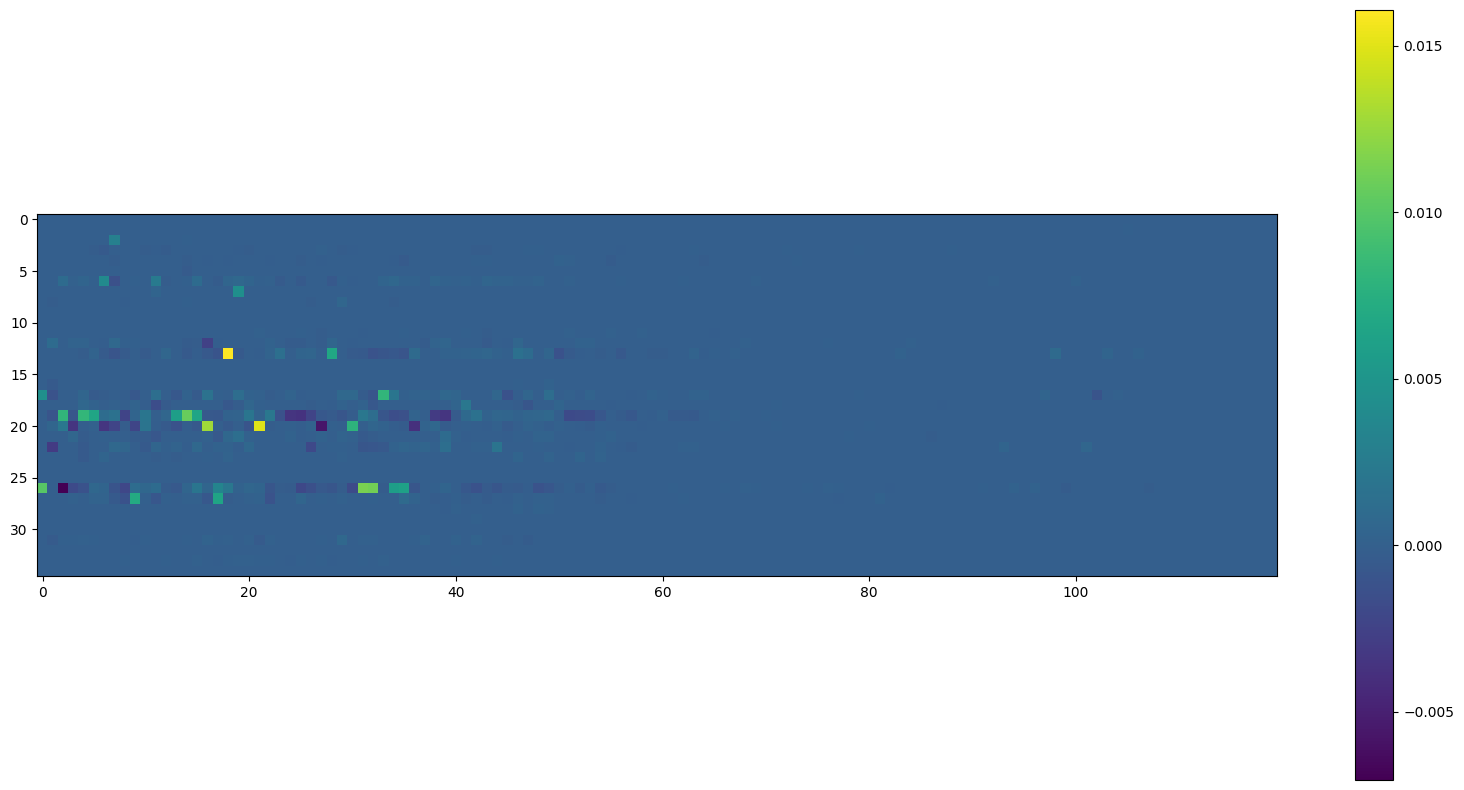

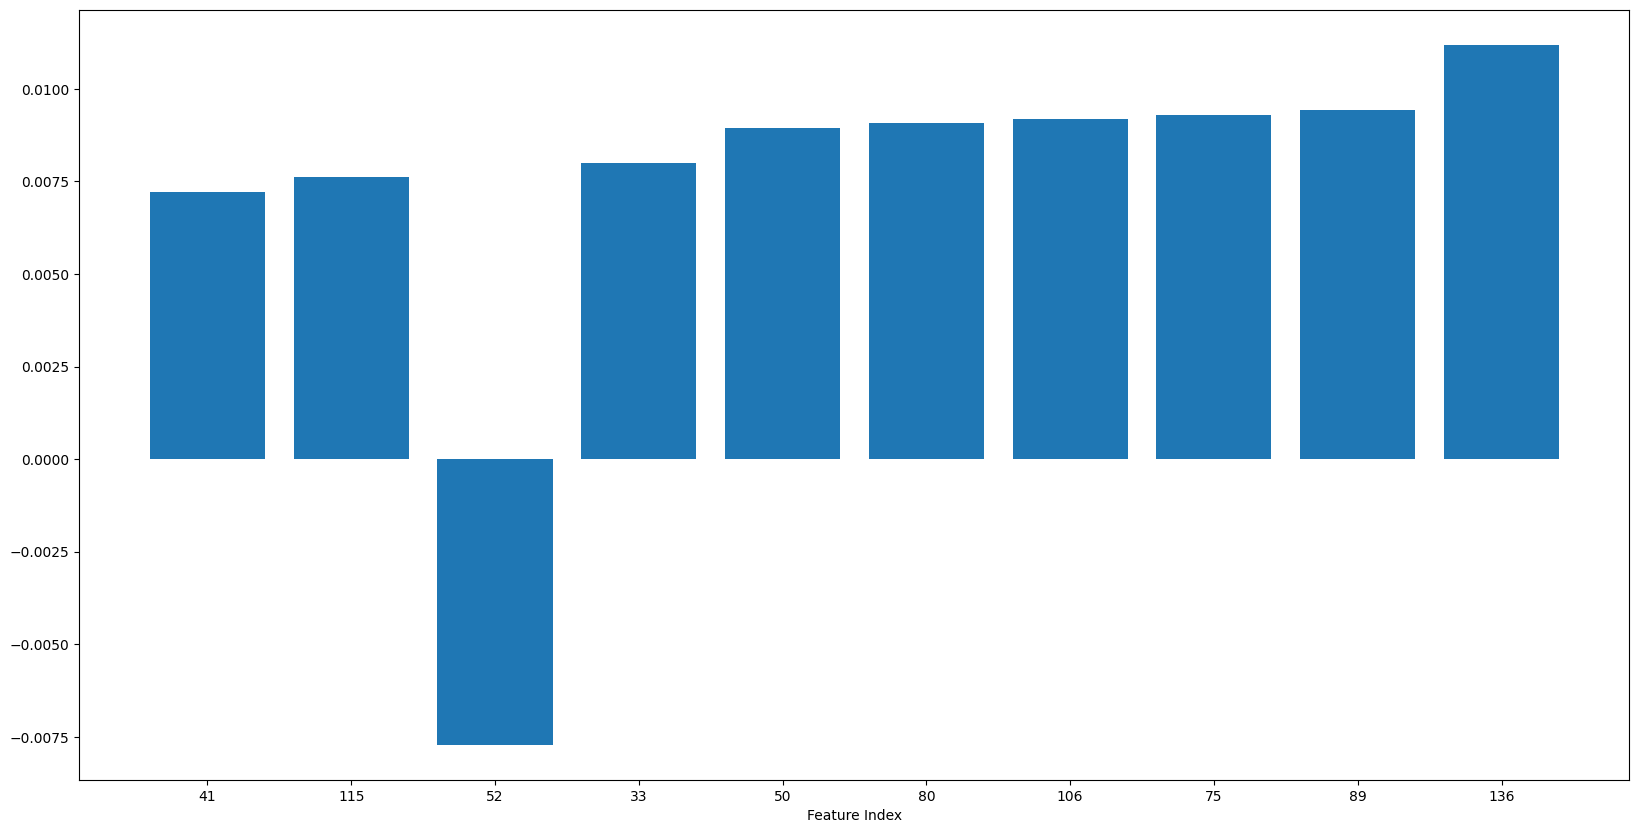

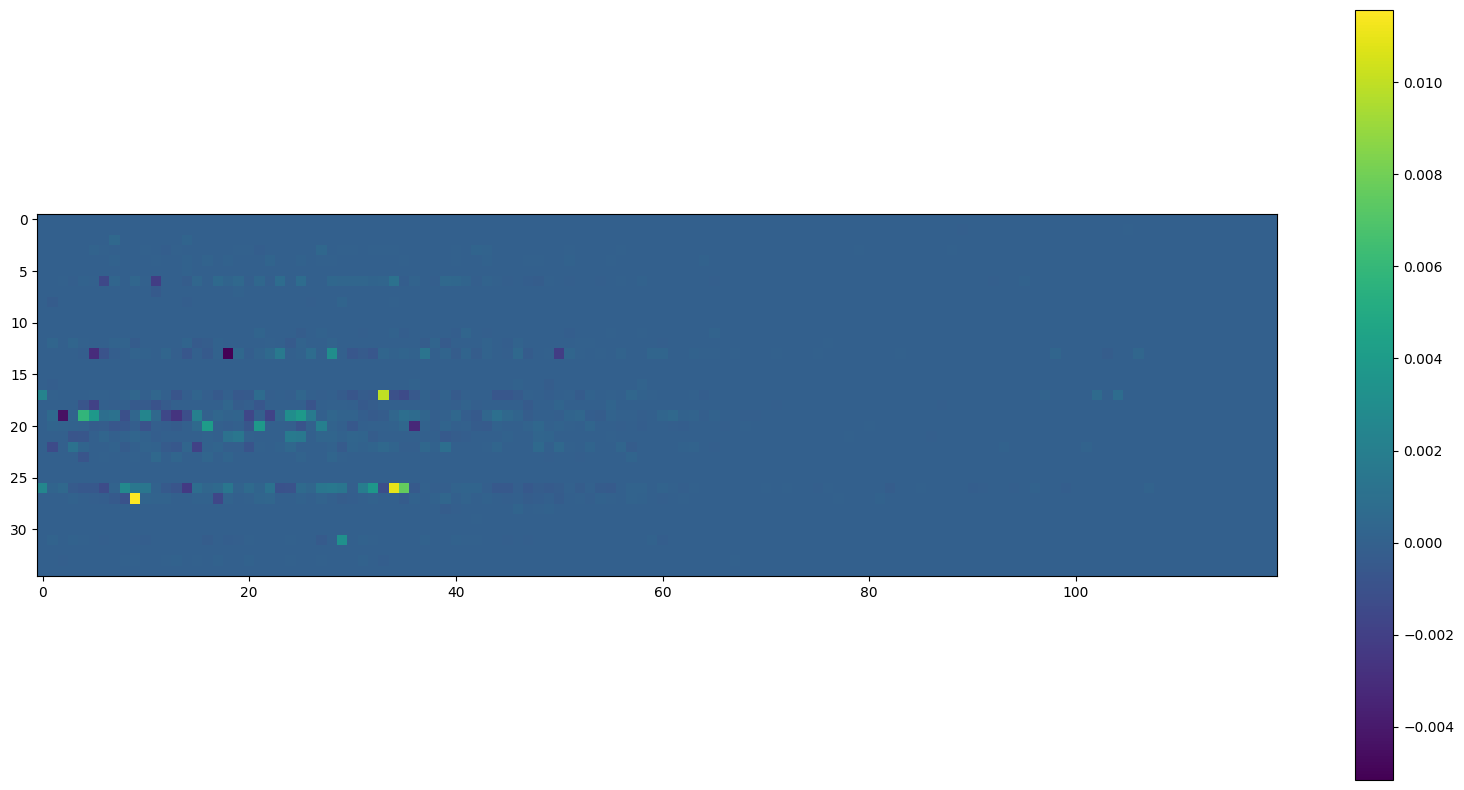

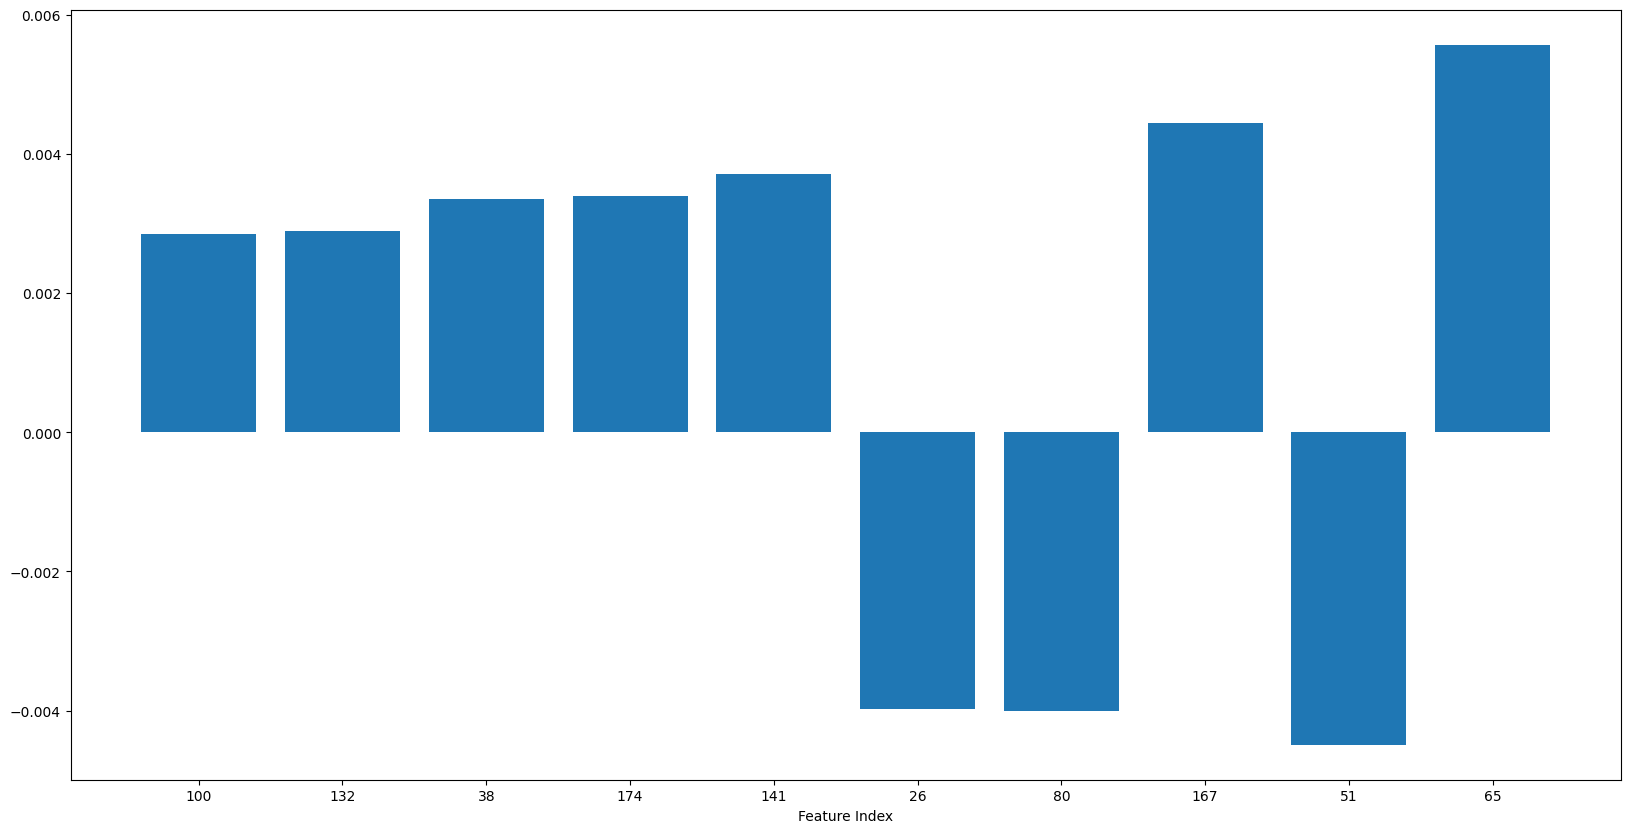

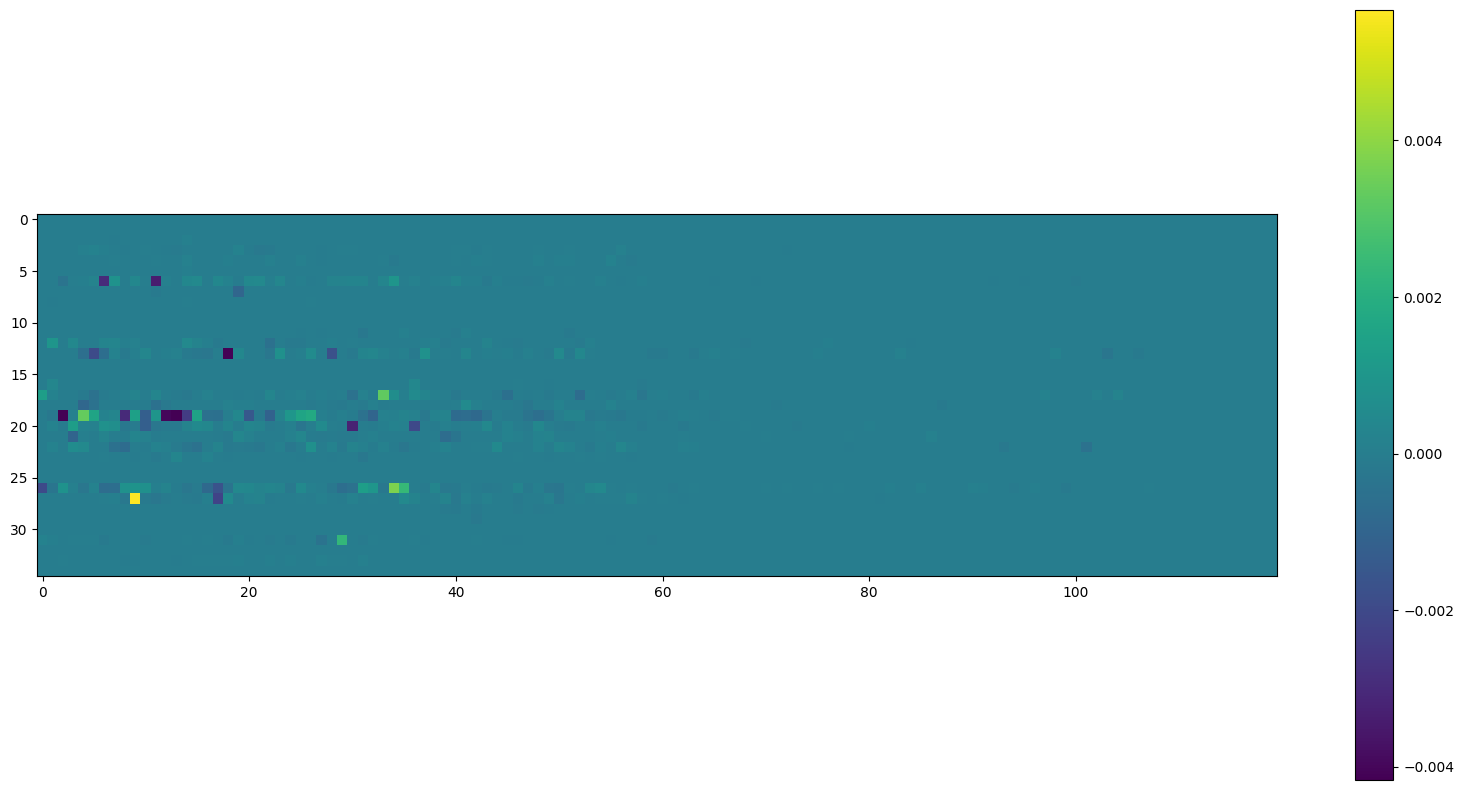

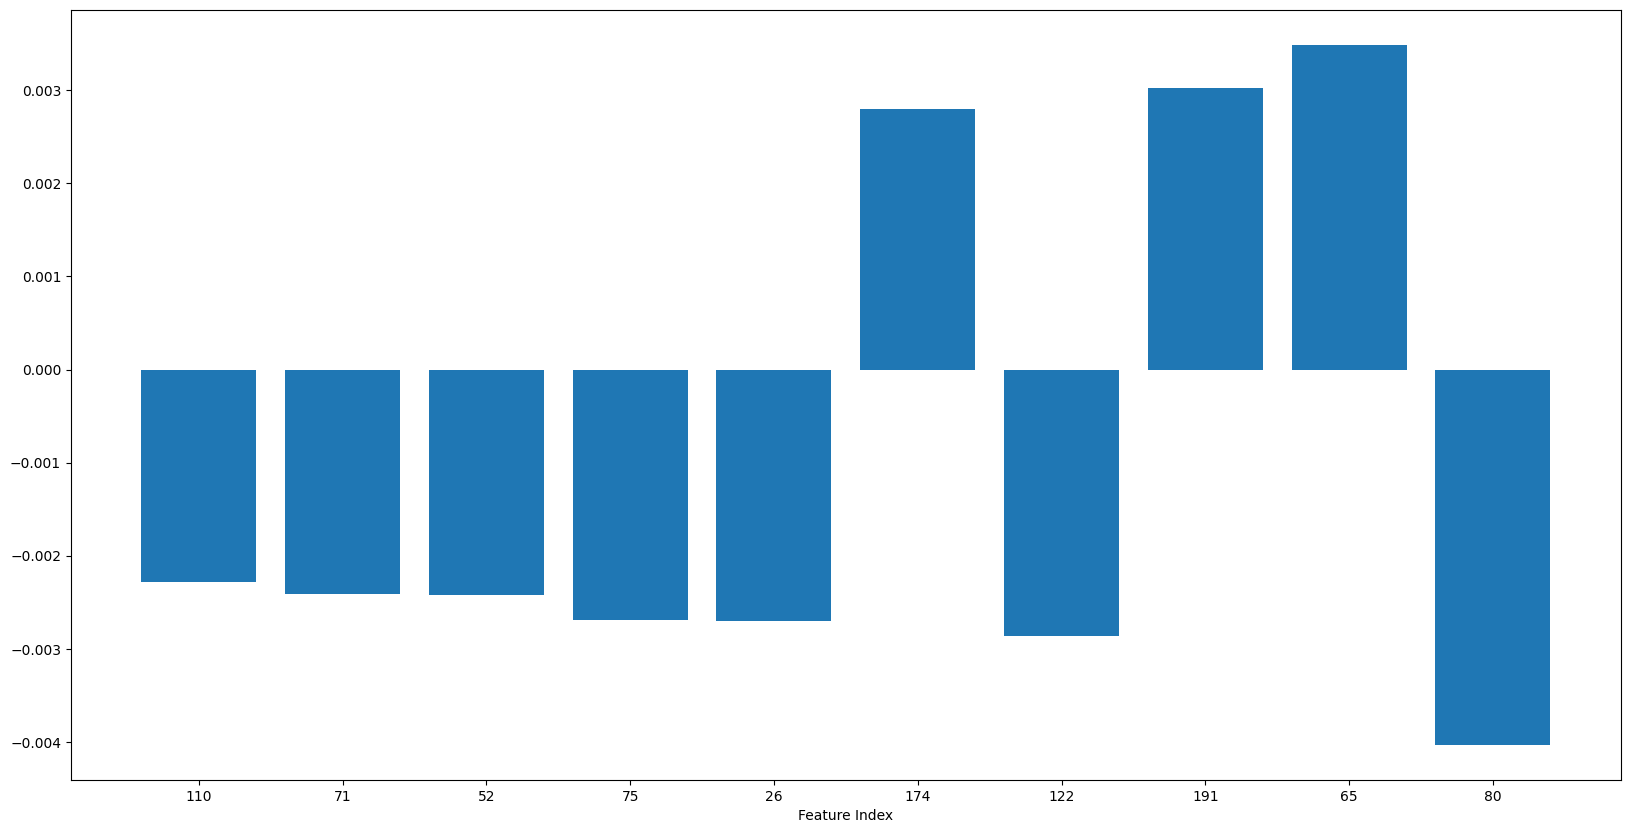

In [40]:
path_save_chem = "./Integrated_gradients_example/BRD-K27305650/"
for c in [10,19,28]:
        
    path_binaryClass_model = "/nfs/turbo/umms-welchjd/wzqian/model_save/lincs-drug-newsplit/classifier/cluster"
    path_binaryClass_model = path_binaryClass_model + str(c) + "/"
        
    model_class = BinaryCellStatesClass().to(device)
    model_class.load(path_binaryClass_model)
    model_class.eval()

    fModel_zLabel = FlowResizeLabelClass(model = model_c, model_g = model_g, model_class = model_class,
                                             std_model = std_model, zDim = 10, yDim = 196,
                                             n_seq = 120, n_vol = 35, device = device)

    yModel_zLabel = FlowResizeYLabelClass(model = model_c, model_g = model_g, model_class = model_class,
                                              std_model = std_model, zDim = 10, yDim = 196,
                                              n_seq = 120, n_vol = 35, device = device)


    ig_lab_f = IntegratedGradients(fModel_zLabel)
    ig_lab_y = IntegratedGradients(yModel_zLabel)


    d = 0
    score_start = ig_b_score_compute(ig = ig_lab_f,
                                         input_data = input_end_f,
                                         baseline_null = input_start_f,
                                         target = d,
                                         batch_size = 32,
                                         ifPlot = True,
                                         plot_save_file = os.path.join(path_save_chem,  chem_id + '_b_keptDrug_'+ '_cluster_' + str(c) + '_end_over_cinnKeptRandom_' + str(d) + '.png'))
    pd.DataFrame(score_start.copy()).to_csv(os.path.join(path_save_chem,  chem_id + '_b_keptDrug_'+ '_cluster_' + str(c) + '_end_over_cinnKeptRandom_' + str(d) + '.csv'))

    d = 0
    score_start = ig_y_score_compute(ig = ig_lab_y,
                                         input_data = input_end_y,
                                         baseline_null = input_start_y,
                                         target = d,
                                         batch_size = 32,
                                         ifPlot = True,
                                         plot_save_file = os.path.join(path_save_chem, chem_id + '_y_keptDrug_'  + '_cluster_' + str(c) + '_end_over_cinnKeptRandom_' + str(d) + '.png'))

    pd.DataFrame(score_start.copy()).to_csv(os.path.join(path_save_chem,  chem_id + '_y_keptDrug_' + '_cluster_' + str(c) + '_end_over_cinnKeptRandom_' + str(d) + '.csv'))

**BRD-K27305650 attribution score for cluster 11, 29 (10 and 28 due to cluster index)**

/home/wzqian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


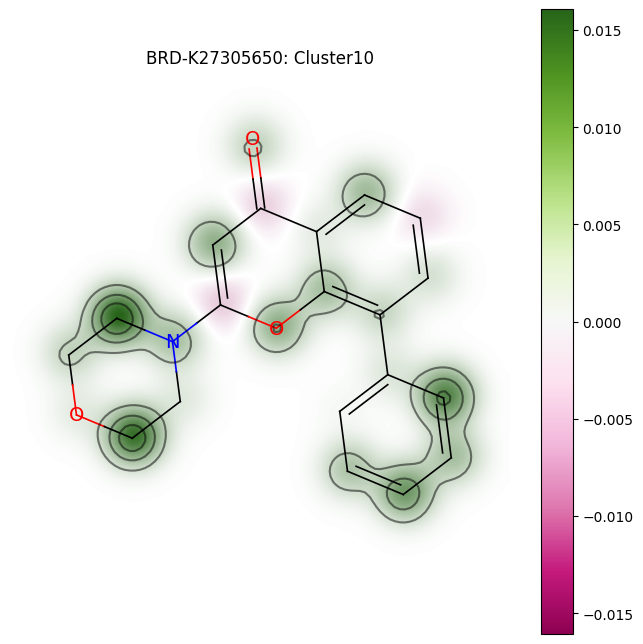

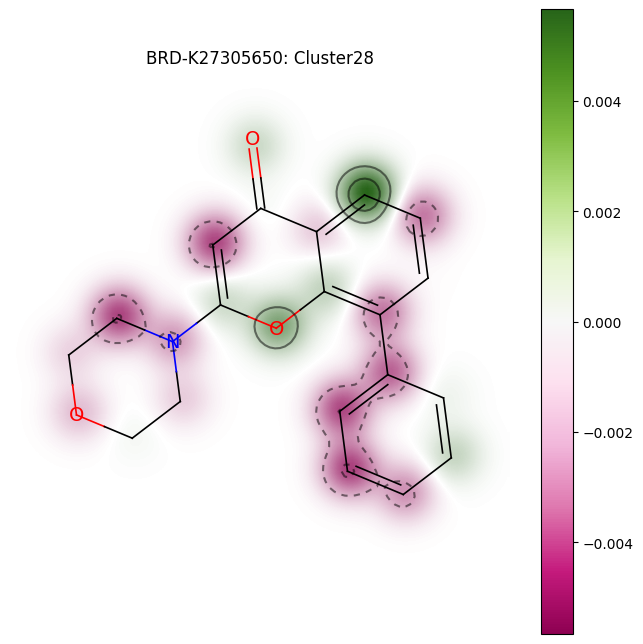

In [48]:

path_save = "./Integrated_gradients_example/"

   


path_save_chem = path_save + chem_id + "/"
paht_save_atom_scores = path_save_chem  + "molecule_scores/"
os.makedirs(paht_save_atom_scores, exist_ok = True)
one_hot_matrix = seen_onehot[34]

for c in [10,28]:
    save_fig_path = paht_save_atom_scores + chem_id + "_cluster" + "_" + str(c) + ".png"
    d = 0
    df_path = os.path.join(path_save_chem,  chem_id + '_b_keptDrug_'+ '_cluster_' + str(c) + '_end_over_cinnKeptRandom_' + str(d) + '.csv')
    df = pd.read_csv(df_path)
    df = df.drop("Unnamed: 0", 1)
    attribution_scores = df.to_numpy()
    plot_molecule_attribtuion_score(trt_type,one_hot_matrix, attribution_scores, str(c),chem_id, save_fig_path, contourLines = 5)


# Calculate the cell density treated by BRD-K27305650

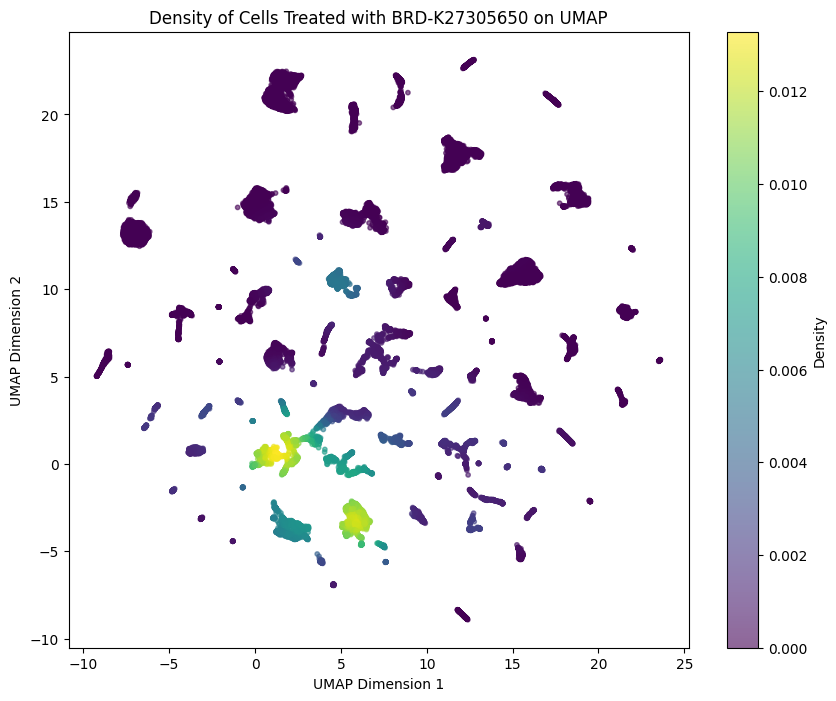

In [49]:

umap_z = adata_downsampled.obsm["umap_z"]
drug_treatment = adata_downsampled.obs["pert_id"].to_numpy()


interested_drug = 'BRD-K27305650'

drug_indices = np.where(drug_treatment == interested_drug)[0]
drug_umap = umap_z[drug_indices]

x = drug_umap[:, 0]
y = drug_umap[:, 1]
kde = gaussian_kde(np.vstack([x, y]))

density = kde(np.vstack([umap_z[:, 0], umap_z[:, 1]]))


plt.figure(figsize=(10, 8))
plt.scatter(umap_z[:, 0], umap_z[:, 1], c=density, s=10, cmap='viridis', alpha=0.6)
plt.colorbar(label='Density')

plt.title(f'Density of Cells Treated with {interested_drug} on UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

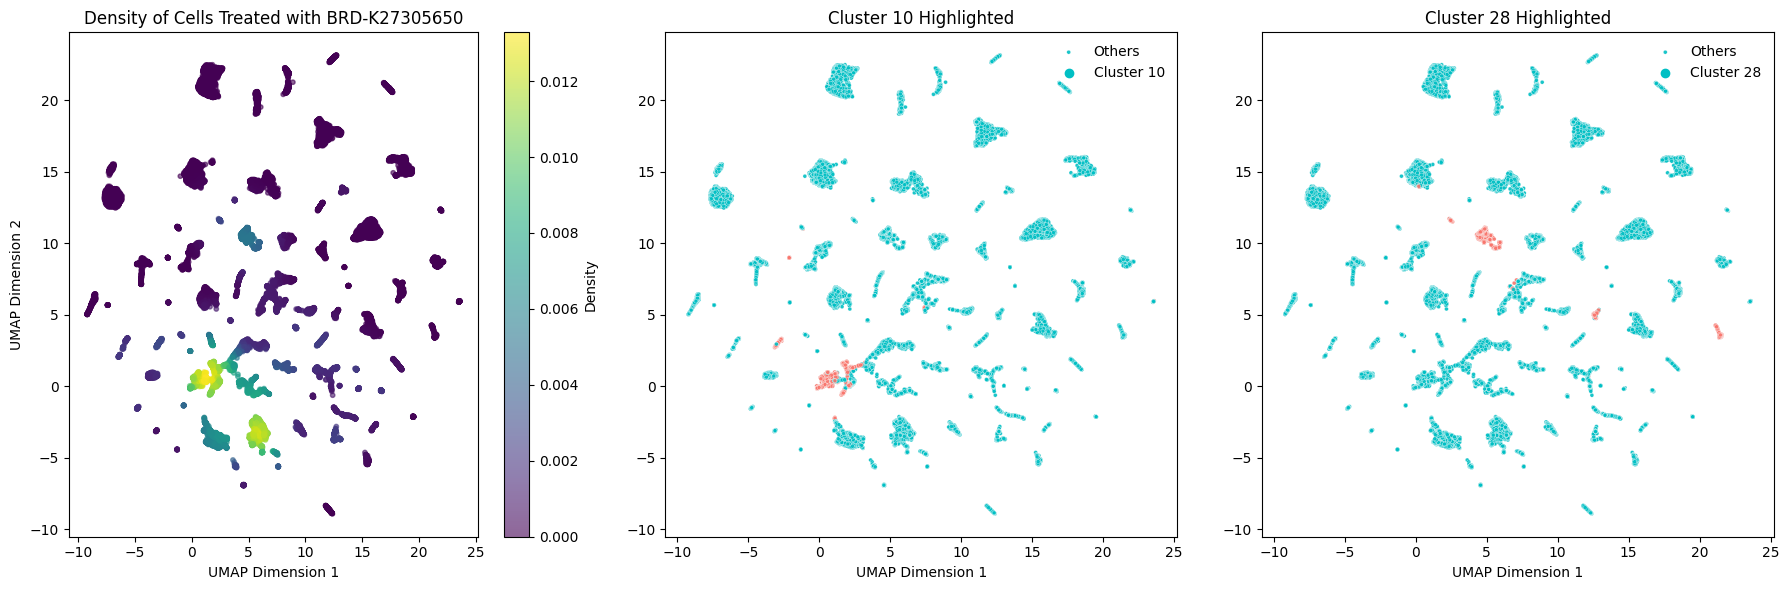

In [58]:
umap_z = adata_downsampled.obsm["umap_z"]
drug_treatment = adata_downsampled.obs["pert_id"].to_numpy()
kmeans_cluster = adata_downsampled.obs["Kmeans30"].astype(str).to_numpy()

interested_drug = 'BRD-K27305650'
cluster1 = '10'
cluster2 = '28'


fig, axes = plt.subplots(1, 3, figsize=(18, 6))


drug_indices = np.where(drug_treatment == interested_drug)[0]
drug_umap = umap_z[drug_indices]
x = drug_umap[:, 0]
y = drug_umap[:, 1]
kde = gaussian_kde(np.vstack([x, y]))
density = kde(np.vstack([umap_z[:, 0], umap_z[:, 1]]))

scatter1 = axes[0].scatter(umap_z[:, 0], umap_z[:, 1], c=density, s=10, cmap='viridis', alpha=0.6)
axes[0].set_title(f'Density of Cells Treated with {interested_drug}')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')
fig.colorbar(scatter1, ax=axes[0], orientation='vertical', label='Density')


colors1 = np.where(kmeans_cluster == cluster1, 'Selected', 'Others')
sns.scatterplot(x=umap_z[:, 0], y=umap_z[:, 1], hue=colors1, palette=['#00BFC4', '#F8766D'], s=8, alpha=0.9, ax=axes[1])
axes[1].set_title(f'Cluster {cluster1} Highlighted')
axes[1].legend(['Others', f'Cluster {cluster1}'], loc='upper right', frameon=False)
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('')


colors2 = np.where(kmeans_cluster == cluster2, 'Selected', 'Others')
sns.scatterplot(x=umap_z[:, 0], y=umap_z[:, 1], hue=colors2, palette=['#00BFC4', '#F8766D'], s=8, alpha=0.9, ax=axes[2])
axes[2].set_title(f'Cluster {cluster2} Highlighted')
axes[2].legend(['Others', f'Cluster {cluster2}'], loc='upper right', frameon=False)
axes[2].set_xlabel('UMAP Dimension 1')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()